In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd
import numpy as np

# Load your data (already preprocessed)
df = pd.read_pickle("untracked_data/data_prepro_train_01.pkl")

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Baseline model: CountVectorizer + L1-regularized Logistic Regression
baseline_model = make_pipeline(
    CountVectorizer(ngram_range = (1,2)),
    LogisticRegression(
        penalty='l1',
        solver='liblinear',   # supports L1
        max_iter=2000,
        random_state=42
    )
)

# Evaluate
scores = cross_val_score(
    baseline_model,
    df['text'],
    df['label'],
    cv=kf,
    scoring='accuracy'
)

print(f"Baseline L1 Logistic Regression accuracy (10-fold CV): {scores.mean():.4f}")


Baseline L1 Logistic Regression accuracy (10-fold CV): 0.8375


In [21]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Load data (negative reviews only; labels: truthful vs deceptive)
df = pd.read_pickle("untracked_data/data_prepro_train_01.pkl")

# --- YOU toggle this manually outside the grid ---
# (1,1) for unigrams, (1,2) for uni+bigrams per the assignment question 3.
ngram_range = (1, 1)   # change to (1, 2) yourself when you run the bigram condition

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=ngram_range)),
    ('clf', LogisticRegression(
        penalty='l1',          # Lasso per assignment
        solver='liblinear',    # supports L1; good for (binary) text problems
        max_iter=2000,
        random_state=42
    ))
])

# What to fluctuate:
# - vectorizer__min_df  → sparse-term removal (your request)
# - clf__C              → L1 regularization strength (model complexity per assignment)
param_grid = {
    'vectorizer__min_df': [1, 2, 3, 5, 10],
    'clf__C': np.logspace(-3, 6, 10)  # 1e-3 … 1e2
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,                 # you may also use the provided folds or 10-CV as allowed
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(df['text'], df['label'])

print("Best params:", grid.best_params_)
print(f"Best mean CV accuracy: {grid.best_score_:.4f}")


Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END .................clf__C=0.001, vectorizer__min_df=1; total time=   0.2s
[CV] END .................clf__C=0.001, vectorizer__min_df=1; total time=   0.2s
[CV] END .................clf__C=0.001, vectorizer__min_df=1; total time=   0.2s
[CV] END .................clf__C=0.001, vectorizer__min_df=1; total time=   0.2s
[CV] END .................clf__C=0.001, vectorizer__min_df=1; total time=   0.2s
[CV] END .................clf__C=0.001, vectorizer__min_df=1; total time=   0.2s
[CV] END .................clf__C=0.001, vectorizer__min_df=1; total time=   0.2s
[CV] END .................clf__C=0.001, vectorizer__min_df=1; total time=   0.2s
[CV] END .................clf__C=0.001, vectorizer__min_df=2; total time=   0.1s
[CV] END .................clf__C=0.001, vectorizer__min_df=2; total time=   0.1s
[CV] END .................clf__C=0.001, vectorizer__min_df=2; total time=   0.1s
[CV] END .................clf__C=0.001, vector

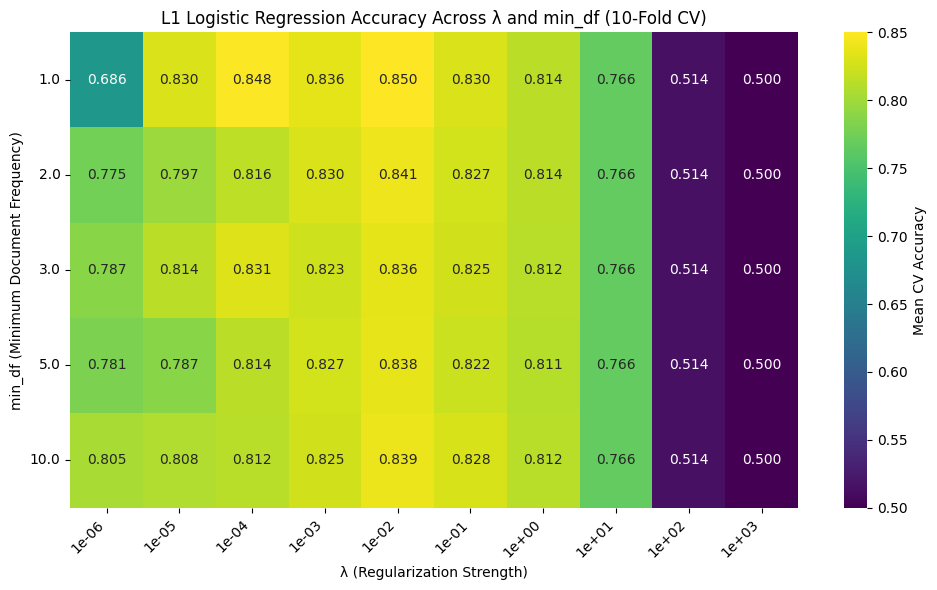

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

results = pd.DataFrame(grid.cv_results_)[[
    'param_vectorizer__min_df', 'param_clf__C', 'mean_test_score'
]]

# Ensure numeric
results['param_vectorizer__min_df'] = results['param_vectorizer__min_df'].astype(float)
results['param_clf__C'] = results['param_clf__C'].astype(float)

# Work in lambda for display if you like
results['lambda'] = 1.0 / results['param_clf__C']

pivot = (results
         .pivot(index='param_vectorizer__min_df',
                columns='lambda',
                values='mean_test_score')
         .sort_index(ascending=True)
         .sort_index(axis=1, ascending=True))

# Nicely formatted λ tick labels
lambda_ticks = np.array(pivot.columns, dtype=float)
lambda_labels = [f"{l:.0e}" for l in lambda_ticks]
pivot.columns = lambda_labels


plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={'label': 'Mean CV Accuracy'}
)


plt.title("L1 Logistic Regression Accuracy Across λ and min_df (10-Fold CV)")
plt.xlabel("λ (Regularization Strength)")
plt.ylabel("min_df (Minimum Document Frequency)")

# Make x labels readable
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

